In [2]:
import random as rd
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [3]:
def prob_selection(p):
    #Returns True with probability p, False with probability 1-p
    # Based on this randomness or the probablity GA applies operator's crossover_tsp & mutation on population
    r = rd.uniform(0, 1)
    return r <= p

In [4]:
#Mutation function
def mutate_tsp(ind, N):
    # Causes mutations by exchanging 2 random chromosomes: array of N chromosomes
    
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    ind[i], ind[j] = ind[j], ind[i]

In [5]:
# Cross exchange function
def crossover_tsp(father, mother, child1, child2, N):
    # father and mother are two chromosomal arrays, father and mother, with N elements
    # child1 and child2 are two child chromosome arrays with N 
    
    # Choose a random cross-over range
    # Convention i <= j
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    if i > j:
        i, j = j, i

    check1 = np.zeros(N)
    check2 = np.zeros(N)

    for x in range(i, j + 1):
        child1[x] = father[x]  # Child 1 inherits the gene segment [i, j] from the father
        child2[x] = mother[x]  # Child 2 inherits the gene segment [i, j] from the mother
        check1[father[x]] = 1
        check2[mother[x]] = 1

    # Sequential copying of the remaining genome of offspring 1
    # offspring 1 inherits the [0, i-1] and [j+1, N-1] genes of the mother
    x = 0
    index = 0 + ((i == 0) * (j + 1)) #index = 0 if i != 0, otherwise index = j + 1
    while x < N and index < N:
        if not check1[mother[x]]:
            child1[index] = mother[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

    # Sequential copying of the remaining genome of offspring 2
    # Offspring 2 inherits the gene segments [0, i-1] and [j+1, N-1] of the father
    x = 0
    index = 0 + ((i == 0) * (j + 1))
    while x < N and index < N:
        if not check2[father[x]]:
            child2[index] = father[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

In [6]:
#Function to calculate euclidean distance of 1 cycle

def ecl_distance(points, order, N):
    # points is a 2-dimensional Nx2 array that stores a list of point coordinates
    # order is an ordered array of N points
    # Returns: the euclidean distance of the point period
    # For example:
    #     >>>ecl_distance([[0, 0], [0, 4], [3,0]], [0, 1, 2], 3)
    #     12.0
    
    x0 = points[0][0]
    y0 = points[0][1]
    xi = points[order[0]][0]
    yi = points[order[0]][1]
    s = round(math.sqrt((x0 - xi) ** 2 + (y0 - yi) ** 2)) #Euclidean distance

    for i in range(1, N):
        x1 = points[order[i - 1]][0]
        y1 = points[order[i - 1]][1]
        x2 = points[order[i]][0]
        y2 = points[order[i]][1]
        s += round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
    xn = points[order[N-1]][0]
    yn = points[order[N-1]][1]
    s += round(math.sqrt((x0 - xn) ** 2 + (y0 - yn) ** 2))
    return float(s)

In [7]:
# The population initialization function has K chromosomes with N genomes for each chromosome

def init_population(K, N):
    # Returns a 2-dimensional K x N array
    pop = np.zeros((K, N), dtype=np.int32)
    # Shuffling chromosomes
    seq = list(range(N))
    for i in range(K):
        rd.shuffle(seq)
        pop[i] = seq
    return pop

In [8]:
# Fitness function
def compute_population_fitness(pop, points, K, N):
    # The fitness of each chromosome is the negative value of its cycle distance
    # Returns a K-element fit array with fit[k] = fitness of pop[k]
    # For example
    #     >>>compute_population_fitness([[0,3,1,2],[2,1,0,3]],[[0,0],[0,4],[3,4],[3,0]],2,4)
    #     array([-16., -14.])
        
    fit = np.zeros(K)
    for k in range(K):
        fit[k] = -ecl_distance(points, pop[k], N)
    return fit

In [9]:
#Cumulative distribution function

def find_cumulative_distribution(arr, K):
    #     Where arr is an array with K numbers
    # Returns:
    #     The array cd has K elements, where cd[k] is the probability of any number in the segment [0, arr.sum()]s
    #     less than or equal to arr[:k].sum()
    # For Example:
    #     >>>find_cumulative_distribution(np.array([4,2,2]),3)
    #     array([ 0.5 ,  0.75,  1.  ])
    #     The probability that any number in [0, 8] is less than or equal to 4 is 0.5

    cd = np.zeros(K)
    acc = 0
    s = arr.sum()
    for i in range(K):
        acc += arr[i] / s
        cd[i] = acc
    return cd

In [10]:
# The parent selection function is based on the fitness of each chromosome, using the roulette wheel technique.
def select_parent(fit, K):
    #     Returns the index of the parent
    
    local_absolute_fitness = fit - fit.min()  # Min fitness = 0
    # Choose a random number representing the parent using the cumulative probability of each element.
    cd = find_cumulative_distribution(local_absolute_fitness, K)
    roulette = rd.uniform(0, 1)
    ind = 0
    while roulette > cd[ind]:
        ind += 1
    return ind

In [11]:
# Create a new population of K chromosomes with N genomes using crossover_tsp + mutation on the current population
def create_new_population(pop, fitness, K, N, crossover_tsp_probability, mutation_probability):
    #     crossover_tsp probability is the crossover_tsp rate
    # mutation_probability is the mutation rate
    # Return:
    #     2-dimensional K x N array
    
    new_pop = np.zeros((K, N), dtype=np.int32)
    for k in range(K // 2):  # Each loop creates 2 children
        #Parental selection
        father_ind = select_parent(fitness, K)
        mother_ind = select_parent(fitness, K)
        father = pop[father_ind]
        mother = pop[mother_ind]

        #Initialize 2 children from father and mother
        child1 = father.copy()
        child2 = mother.copy()

        #If there is a cross exchange rate, perform a crossover_tsp between father, mother and 2 children
        #If there is a mutation rate, perform the mutation on the chromosome under considerations
        if prob_selection(crossover_tsp_probability):
            crossover_tsp(father, mother, child1, child2, N)
        if prob_selection(mutation_probability):
            mutate_tsp(child1, N)
        if prob_selection(mutation_probability):
            mutate_tsp(child2, N)

        new_pop[k * 2] = child1
        new_pop[k * 2 + 1] = child2
    return new_pop

In [12]:
# Find the individual (NST) with the highest fitness in all generations

def find_best_individual(pop, fitness, best_individual, best_fit):
    # Returns the best individual and its highest fitness index
    
    current_best_index = fitness.argmax()
    current_best_fit = fitness[current_best_index]
    current_best_individual = pop[current_best_index]

    if best_fit < current_best_fit:
        return current_best_individual, current_best_fit
    else:
        return best_individual, best_fit

In [13]:
#Input function

def read_input(path, N):
    points = np.zeros((N, 2))
    file = open(path)
    lines = file.readlines()
    lines = [x.replace(',',' ') for x in lines]
    file.close()
    for i in range(N):
        points[i][0], points[i][1] = map(int, lines[i].split())
    return points

In [14]:
# Draw an individual cycle diagram

def plot_individual_path(individual, points, title, index):
    x = []
    y = []
    for i in individual:
        x.append(points[i][0])
        y.append(points[i][1])
    x.append(x[0])
    y.append(y[0])

    plt.subplot(3, 5, index)
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.plot(x, y, 'r*')
    plt.plot(x, y, 'g--')
    # plt.savefig("path_cycle.png")

In [15]:
# Draw the results of up to 15 best individuals (chromosomes) across generations

def plot_results(best_last_15, points):
    '''
    best_last_15 is a 2-way queue
    '''
    for i in range(0, len(best_last_15)):
        plot_individual_path(best_last_15[i][0], points, str(round(best_last_15[i][1], 2)), i+1)
    plt.show()

In [16]:

def TSP_genetic(n, k, max_generation, crossover_tsp_probability, mutation_probability, path):
    '''
    Solves the Traveling Sales Person Problem using genetic algorithm with chromosomes decoded
    as cycles (solutions) of traveling Order 1 crossover_tsp, Swap mutation, complete generation 
    replacement, Roulette Wheel Technique for choosing parents and negative of cycle distance for fitness.
    
    
    Args:
        n: integer denoting the number of points and also the number of genome of each chromosom 
        k: integer denoting the number of chromosomes in each population
        max_generation: integer denoting the maximum generation (iterations) of the algorithm
        crossover_tsp_probability: float in [0,1] denoting the crossover_tsp probability
        mutation_probability: float in [0,1] denoting the mutation probability
        path: string that indicates the path to the text file containing coordinates of n points
    Returns:
        None
    '''
    points = read_input(path, n)
    population = init_population(k, n)
    best_individual = population[0]  # Choose the first individual as the best individual
    best_fitness = -ecl_distance(points, best_individual, n)
    old_best_fitness = best_fitness
    best_last_15 = deque([], maxlen=15)
    len_path = []
    #len_path.append(-best_fitness)
    for generation in range(1, max_generation + 1):
        # 1. Calculate the fitness of each individual in the population
        fitness = compute_population_fitness(population, points, k, n)
        # 2.Find the individual with the highest fitness
        best_individual, best_fitness = find_best_individual(population, fitness, best_individual, best_fitness)
        # 3. Save the last 15 individuals
        if old_best_fitness != best_fitness:
            old_best_fitness = best_fitness
            best_last_15.append((best_individual.copy(), -best_fitness))
        # 4. Create a new generation
        population = create_new_population(population, fitness, k, n, crossover_tsp_probability, mutation_probability)
        # 5. Print the current highest fitness score
        print("Generation = ", generation,'\t',"Path length = ", -best_fitness)
        len_path.append(-best_fitness)
    solution = best_individual
    cycle_distance = -best_fitness

    # print('cycle distance : =======>', cycle_distance)
    #print(solution+1)
    #plot_results(best_last_15, points)

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(max_generation), len_path, label='Path length')
    plt.legend(loc='lower right')
    plt.title('Path length')
    plt.savefig("Path_length.png")
    plt.show()
    return solution + 1

In [17]:
from random import choices, randint, randrange, random
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Input
# Parameters for KP and TSP
# Knapsack Problem
parent_size = 2
mutation_prob = 0.5        # tunning parameter
generatoin_limit = 500
population_size = 15        # tunning parameter
init_prob = 0.5            # tunning parameter
fitness_limit = 0        
top_sol = 2                # Top 2 solutions are retained when moving to the next generation

data = [
        # "test-cases/a280-n1395.txt",
        "test-cases/a280-n279.txt",
        # "test-cases/a280-n2790.txt",
        # "test-cases/fnl4461-n22300.txt",
        # "test-cases/fnl4461-n44600.txt",
        # "test-cases/pla33810-n169045.txt",
        # "test-cases/pla33810-n33809.txt",
        # "test-cases/pla33810-n338090.txt"
       ]
#Large files can take a long time to run
# If the files take a longer time to run, try runnig the test-case file one by one.
# Parameter can be tuned according to larger test cases to achive the desired target specified in test cases.

In [19]:
# TSP
max_generation = 200
crossover_tsp_probability = 0.99
mutation_probability = 0.01

In [20]:
# Redefining the Genetic Algorithm for the Knapsack Problem

def generate_genome(length:int, Inputs):
      # Generate a random array of numbers 0 and 1
      # Keeping the last half zero at the start will converge early because we have less distance to move before
      prob = Inputs[3]/np.sum(Inputs[0])
      a = np.random.choice(
                          [0, 1],
                          size=(int(length*Inputs[14]),), p=[1-prob, prob])
      b = np.random.choice(
                          [0, 0],
                          size=(length-int(length*Inputs[14]),), p=[0.5, 0.5])
      return np.append(a,b)

In [21]:
# Function to create population (array of chromosomes)

def generate_population(size:int, genome_length:int, Inputs):
    return [generate_genome(genome_length, Inputs) for i in range(size)]

In [22]:
# Select pairs to create a new generation

def selection_pair(population):
    new_population = choices(population=population,
                            weights= [fitness(genome, Inputs) for genome in population],
                            k = Inputs[8]
                            )
    return new_population

In [23]:
  #Fitness function

def fitness(genome, Inputs):
    w = 0   # Weight
    v = 0   # Speed when moving through a city
    p = 0  # Profit
    t = 0   # Time spent traveling through a city


    #Profit of items in current city
    loop_profit= np.zeros(len(Inputs[1]))

    for i in range(1,len(genome)+1):
        # Add weight of 1 item
        w += genome[i-1] * Inputs[0][i-1]
        if w <= Inputs[3]:

            #Velocity = (vmax - (vmax - vmin) * (current weight / weight limit))
            v = Inputs[4] - (Inputs[4]-Inputs[5])*(w/Inputs[3])

            # Check when moving to a city
            if (i) % Inputs[7] == 0 and i < len(genome):

                # Calculate travel time = distance / velocity
                t = np.abs(Inputs[2][i-1]-Inputs[2][i])/v
                loop_profit[i: i+Inputs[7]] = (Inputs[1][i: i+Inputs[7]]) / (t * Inputs[2][i: i+Inputs[7]])
            # More profits
            p += loop_profit[i-1]
            p = p - (p/Inputs[13])
        if w > Inputs[3]:
            p = 1e-10
            break
    return p

In [24]:
# Cross 1 point
def single_point_crossover_knp(a,b):
    p = randint(1, len(a)-1)
    if len(a) == len(b) and len(a) > 2:
        return a, b
    return a[0: p] + b[p:] , b[0: p] + a[p:]

In [25]:
#Mutation
def mutation(genome,Inputs):
    index = randrange(len(genome))
    if random()>Inputs[9]:
        genome[index] = genome[index]
    else:
        genome[index] = abs(genome[index]-1)
    return genome

In [26]:
# cal time
def cal_time(genome, Inputs):
    t = 0   # Time spent traveling through a city
    w = 0
    for i in range(1,len(genome)+1):
        # Add weight of 1 item
        w += genome[i-1] * Inputs[0][i-1]
        if w <= Inputs[3]:

            #Velocity = (vmax - (vmax - vmin) * (current weight / weight limit))
            v = Inputs[4] - (Inputs[4]-Inputs[5])*(w/Inputs[3])

            # Check when moving to a city
            if (i) % Inputs[7] == 0 and i < len(genome):

                # Calculate travel time = distance / velocity
                t = np.abs(Inputs[2][i-1]-Inputs[2][i])/v

        if w > Inputs[3]:
            break
    return t

In [27]:
# Function that runs the GA algorithm for Knapsack
def run_evolution(pop_size, genome_length, Inputs):
    prof= 0
    weg = 0
    pop = generate_population(pop_size, genome_length, Inputs)
    profits = []
    weights = []
    time = []
    for i in range(Inputs[10]):
        pop = sorted(pop, key=lambda genome: fitness(genome, Inputs), reverse=True)
        prof = np.sum(new_profit * pop[0])
        weg = np.sum(new_weights * pop[0])
        next_gen = pop[0: Inputs[12]]
        time = cal_time(pop[0], Inputs)

        for j in range(int(len(pop) / 2) - int(Inputs[12] / 2)):
            parents = selection_pair(pop)
            child_a,child_b = single_point_crossover_knp(parents[0], parents[1])
            child_a =  mutation(child_a, Inputs)
            child_b = mutation(child_b, Inputs)
            next_gen += [child_a, child_b]

        next_gen = sorted(next_gen, key=lambda genome: fitness(genome, Inputs), reverse=True)
        n_prof = np.sum(new_profit * next_gen[0])
        n_weg = np.sum(new_weights * next_gen[0])
        print("Generation = ", i,'\t',"Profit = ",n_prof,'\t',"Weight = ",n_weg,'\t',"Time = ",time)
        profits.append(n_prof)
        weights.append(n_weg)

        if n_weg > Inputs[3]:
            print('\n',"Knapsack capacity exceeded")
            print("Max profit = ", prof)
            print("Knapsack weight = ", weg)
            break
        else:
            pop = next_gen

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(profits)), profits, label='Profits')
    plt.plot(range(len(weights)), weights, label='Weights')
    plt.legend(loc='lower right')
    plt.title('Profits and Weights')
    plt.savefig("profit_weight.png")
    plt.show()
    print('max profits',max(profits))
    return pop[0]

test-cases/a280-n279.txt
Generation =  1 	 Path length =  31317.0
Generation =  2 	 Path length =  31317.0
Generation =  3 	 Path length =  30584.0
Generation =  4 	 Path length =  30584.0
Generation =  5 	 Path length =  30584.0
Generation =  6 	 Path length =  30584.0
Generation =  7 	 Path length =  30584.0
Generation =  8 	 Path length =  30584.0
Generation =  9 	 Path length =  30584.0
Generation =  10 	 Path length =  30131.0
Generation =  11 	 Path length =  30131.0
Generation =  12 	 Path length =  30131.0
Generation =  13 	 Path length =  30131.0
Generation =  14 	 Path length =  30131.0
Generation =  15 	 Path length =  29622.0
Generation =  16 	 Path length =  29622.0
Generation =  17 	 Path length =  29342.0
Generation =  18 	 Path length =  29256.0
Generation =  19 	 Path length =  29256.0
Generation =  20 	 Path length =  29256.0
Generation =  21 	 Path length =  29256.0
Generation =  22 	 Path length =  29256.0
Generation =  23 	 Path length =  29256.0
Generation =  24 	

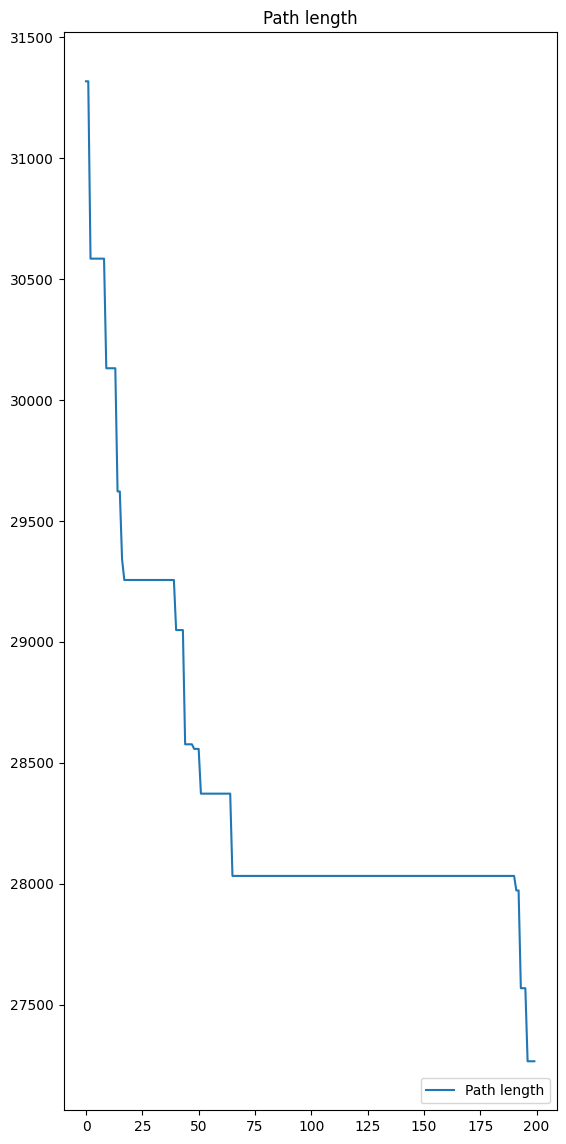

best path ============> 280
Generation =  0 	 Profit =  8752.0 	 Weight =  6952.0 	 Time =  239.86503516403104
Generation =  1 	 Profit =  9848.0 	 Weight =  8248.0 	 Time =  239.86503516403104
Generation =  2 	 Profit =  10478.0 	 Weight =  8778.0 	 Time =  254.97774512769547
Generation =  3 	 Profit =  10945.0 	 Weight =  9145.0 	 Time =  261.7212433049823
Generation =  4 	 Profit =  12945.0 	 Weight =  10745.0 	 Time =  266.60371071136086
Generation =  5 	 Profit =  17432.0 	 Weight =  14532.0 	 Time =  290.20638775322
Generation =  6 	 Profit =  20975.0 	 Weight =  17475.0 	 Time =  367.1368571695237
Generation =  7 	 Profit =  20975.0 	 Weight =  17475.0 	 Time =  462.39427927707305
Generation =  8 	 Profit =  22917.0 	 Weight =  18817.0 	 Time =  462.39427927707305
Generation =  9 	 Profit =  22441.0 	 Weight =  18741.0 	 Time =  524.4427655626786
Generation =  10 	 Profit =  26505.0 	 Weight =  22105.0 	 Time =  520.4873691987077
Generation =  11 	 Profit =  30023.0 	 Weight =  

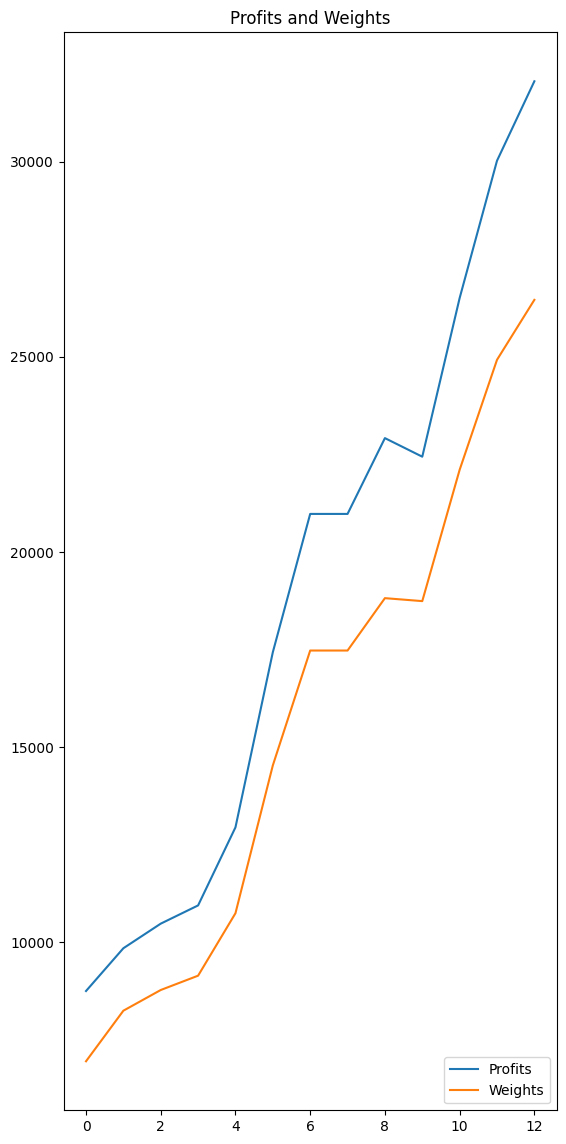

max profits 32059.0


In [28]:
# Read data files
for data_file in data:
  print(data_file)
  with open(data_file, "r") as f:
      lines = f.readlines()
      lines = lines[2:]
      lines = [x.strip() for x in lines]
      lines = [x.replace(':','') for x in lines]
      lines = [x.replace('(','') for x in lines]
      lines = [x.replace(')','') for x in lines]
      lines = [x.split('\t') for x in lines]

      for i in range(len(lines)):

          # Read coordinates
          if lines[i][0] == "NODE_COORD_SECTION":
              start=i

          # Read the number of points (points or dimensions)
          if lines[i][0] == "DIMENSION":
              dimension=int(lines[i][1])

          # Read the number of items (items)
          if lines[i][0] == "NUMBER OF ITEMS ":
              items=int(lines[i][1])

          # Read the capacity of the backpack (capacity)
          if lines[i][0] == "CAPACITY OF KNAPSACK ":
              weight_limit=int(lines[i][1])

          # Read minimum speed
          if lines[i][0] == "MIN SPEED ":
              vmin = float(lines[i][1])

          # Read maximum speed
          if lines[i][0] == "MAX SPEED ":
              vmax = float(lines[i][1])

          #Read the rental rate
          if lines[i][0] == "RENTING RATIO ":
              rent_ratio = float(lines[i][1])


      # Suppose all cities have the same number of items
      item_per_city = int(items / (dimension-1))

      # Read location
      loc = np.array(lines[start+1: start+dimension+1])
      loc[loc == ''] = 0
      loc = loc.astype(np.int32)

      # Sort position by index
      loc = loc[np.argsort(loc[:, 0])]
      # Starting point
      start_loc = [loc[0, 1] ,loc[0, 2]]
      x_loc = loc[:, 1]
      y_loc = loc[:, 2]
      xy_loc = np.transpose(np.matrix([x_loc, y_loc])) # Matrix transposition

      #Record x, y position for TSP
      with open('nodes.txt','wb') as f:
          for line in xy_loc:
              np.savetxt(f, xy_loc, delimiter=',', fmt='%i')

      # Calculate the distance matrix between points
      dist_mat = np.zeros((dimension, dimension))


      for i in range(0,len(loc)):
          for j in range(0,len(loc)):
              dist_mat[i][j] = round(np.sqrt((loc[i][1]-loc[j][1])**2 + (loc[i][2]-loc[j][2])**2))
      # Create a data frame
      df_loc = pd.DataFrame(loc, columns=lines[start][1].split(','))
      #loc_sort = df_loc.sort_values(by=['INDEX'])

      # Read the list of items
      bag = np.array(lines[start+dimension+2 : start+dimension+items+2])
      bag[bag == ''] = 0
      bag = bag.astype(np.int32)

      # Sort by assigned cities (last column)
      bag = bag[np.argsort(bag[:,-1])]

    # Call profit the array of values of items after sorting
    # Call weights the array of weights (weights) of the items after sorting
    # Call node is the array that stores items after sorting
      profit = bag[:,1]
      weights = bag[:,2]
      node = bag[:,3]


      # Combine locations and items
      loc_bag = np.insert(bag, [np.ma.size(bag, 1)], [0, 0], axis=1)

      # Create a data frame
      df_loc_bag = pd.DataFrame(
          loc_bag,
          columns=[lines[start+dimension+1][1].split(',') + lines[start][1].split(',')[1:]])

      for i in range(len(df_loc_bag)):
          a = df_loc_bag.loc[i].at[' ASSIGNED NODE NUMBER'].item()
          df_loc_bag.loc[i].at[' X'] = loc[np.where(loc[:,0]==a)[0][0],1]
          df_loc_bag.loc[i].at[' Y'] = loc[np.where(loc[:,0]==a)[0][0],2]


  # Use Genetic Algorithm for TSP

  n = dimension - 1
  k = 120
  path = 'nodes.txt'
  best_path = TSP_genetic(n, k, max_generation, crossover_tsp_probability, mutation_probability, path)
  # Best route from location 0
  best_path = np.insert(best_path, 0, 0)
  print('best path ============>',len(best_path))


  # Create arrays of profits and weights from the best path

  node_weights = np.zeros((len(best_path) - 1) * item_per_city)
  dist = 0
  new_profit = np.zeros(len(profit))
  new_weights = np.zeros(len(weights))

  for i in range(len(best_path)-1):
      x1 = x_loc[best_path[i]]
      x2 = x_loc[best_path[i+1]]
      y1 = y_loc[best_path[i]]
      y2 = y_loc[best_path[i+1]]
      dist += round(np.sqrt((x1-x2)**2 + (y1-y2)**2))
      start = i*item_per_city
      end = start + item_per_city
      node_weights[start : end ] = dist
      new_profit[start : end] = profit[(best_path[i+1] * item_per_city) - item_per_city : (best_path[i+1] * item_per_city)]
      new_weights[start : end] = weights[(best_path[i+1] * item_per_city) - item_per_city : (best_path[i+1] * item_per_city)]



  # Solve Knapsack using Genetic Algorithms

  Inputs = [new_weights, new_profit, node_weights, weight_limit,
            vmax, vmin, best_path, item_per_city, parent_size,
            mutation_prob, generatoin_limit, fitness_limit, top_sol,
            rent_ratio, init_prob]
# Inputs[0] = new_weights
# Inputs[1] = new_profit
# Inputs[2] = node_weights
# Inputs[3] = weight_limit
# Inputs[4] = vmax
# Inputs[5] = vmin
# Inputs[6] = best_path
# Inputs[7] = item_per_city
# Inputs[8] = parent_size
# Inputs[9] = mutation_prob
# Inputs[10] = generatoin_limit
# Inputs[11] = fitness_limit
# Inputs[12] = top_sol
# Inputs[13] = rent_ratio
# Input[14] = init_prob

  if weight_limit < np.sum(new_weights):
      pop = run_evolution(population_size, items, Inputs)
      total_prof = np.sum(new_profit * pop)
  else:
      pop = np.ones(len(population_size))
